# Machine Learning for Asset Managers

## Chapter 2 Deonising and Detoning

In [1]:
import numpy as np
import pandas as pd

### Snippet 2.1 The Marcenko-Pastur PDF

In [2]:
def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q = T/N
    eMin = var * (1 - (1.0 / q) ** 0.5) ** 2
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    
    eVal = np.linspace(eMin, eMax, pts)
    
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** 0.5
    
    if len(pdf.shape) > 1 :
        pdf = pdf.squeeze()
    
    pdf = pd.Series(pdf, index = eVal)
    
    return pdf

### Snippet 2.2 Testing the Marcdnko-Pastur Theorem

In [3]:
from sklearn.neighbors.kde import KernelDensity

def getPCA(matrix) :
    
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1] # arguments for sorting eVal desc
    
    eVal = eVal[indices]
    eVec = eVec[:, indices]
    
    eVal = np.diagflat(eVal)
    
    return eVal, eVec

def fitKDE(obs, bWidth = 0.25, kernel = 'gaussian', x=None) :
    # Fit kernel to a series of obs, and derive the probability of obs
    # x : the array of values on which the fit KDE will be evaluated
    
    if len(obs.shape) == 1 :
        obs = obs.reshape(-1,1)
        
    if x is None :
        x = np.unique(obs).reshape(-1, 1)
        
    if len(x.shape) == 1 :
        x = x.reshape(-1, 1)
        
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    
    logProb = kde.score_samples(x) #log(density)
    pdf = pd.Series(np.exp(logProb), index = x.flatten())
    
    return pdf


x = np.random.normal(size = (10000,1000))


eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

# Marcenko-Pastur pdf
pdf0 = mpPDF(1.0, q = x.shape[0]/float(x.shape[1]), pts = 1000)

# Empricial PDF
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)
    

### Figure 2.1

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(pdf0, label = "Marcenko-Pastur")
ax.plot(pdf1, '--',label = "Empirical:KDE")

ax.set_title('Figure 2.1 A visualiztion of the Marcenko-Pastur theorem\n', fontsize = 18)
ax.set_ylabel('prob[$\lambda$]', fontsize = 15)
ax.set_xlabel('$\lambda$', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.3 Add signal to a random covariance matrix

In [5]:
def getRndCov(nCOls, nFacts) :
    
    w = np.random.normal( size = (nCols, nFacts))
    
    # Random cov matrix, however not full rank
    cov = np.dot(w, w.T)
    
    # Make full rank cov
    cov += np.diag(np.random.uniform(size=nCols)) 
    
    return cov

def cov2corr(cov) :
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std,std)
    
    # Clipping to prevent numerical errors
    corr[corr <-1] = -1
    corr[corr > 1] = 1
    
    return corr

#### Practice

In [6]:
alpha = 0.995
nCols = 1000
nFact = 100
q = 10

cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar = 0)

# make noise + signal covariance matrix (weights = alpha)
cov = alpha * cov + (1-alpha) * getRndCov(nCols, nFact)

corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

### Snippet 2.4 Fitting the Marcenko-Pastur PDF

In [7]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts = 1000) :
    # Fit error
    # Theoretical pdf
    
    # prevent var values in list format
    if hasattr(var, "__len__") :
        if len(var) == 1 :
            var = var[0]
        else :
            raise ValueErroral ("var  must be scalar")
    
    
    pdf0 = mpPDF(var, q, pts)
    # Empirical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    
    return sse


def findMaxEval(eVal, q, bWidth) :
    # Find Max random eVal by fitting Marcenko's distribution
    
    # Scipy.optimize.minimize
    # fun : Theobjective function to be minimized
    # x0 : ndarray, shape(n,), initial guess. array of real emlements of size
    
    out = minimize(fun = lambda *x : errPDFs(*x), x0 = .5, # first arg : var
                   args = (eVal, q, bWidth), bounds = ((1e-5, 1 - 1e-5),))
    
    if out['success'] :
        var = out['x'][0]
    else :
        var = 1
        
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    
    return eMax, var

### Figure 2.2 Fitting the Marcenko-Pastur PDF on a noisy covariance matrix

In [8]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth = 0.01)

nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)


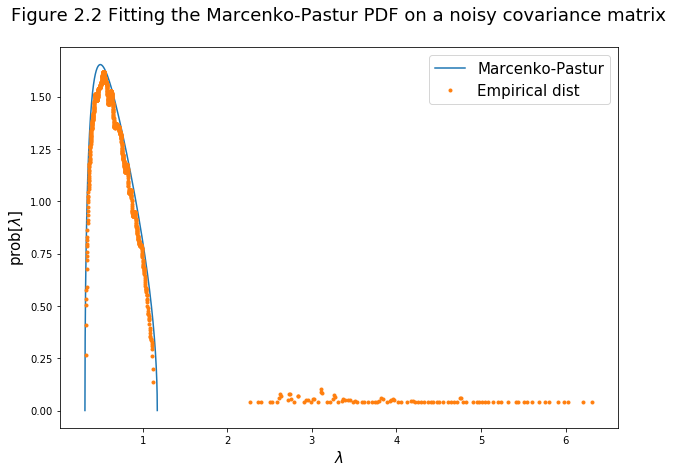

In [9]:
# make graphs

pdf0 = mpPDF(var0, q = q, pts = 1000)


# Empricial PDF
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)



fig, ax = plt.subplots(figsize=(10,7))


ax.plot(pdf0, label = "Marcenko-Pastur")
ax.plot(pdf1,label = "Empirical dist", marker=".", linestyle="")

ax.set_title('Figure 2.2 Fitting the Marcenko-Pastur PDF on a noisy covariance matrix\n', fontsize = 18)
ax.set_ylabel('prob[$\lambda$]', fontsize = 15)

ax.set_xlabel('$\lambda$', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.5 Denoising by constant residual eigenvalue

In [10]:
def denoisedCorr(eVal, eVec, nFacts):
    # Remove noise from corr by fixing randome eigenvalues
    
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)
    
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    
    return corr1

### Figure 2.3 A comparison of eigenvalues before and afterapplying the residual eigenvalue method

In [11]:
# Denoised Corr
corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVac1 = getPCA(corr1)

# Original eigenvalue = eVal0


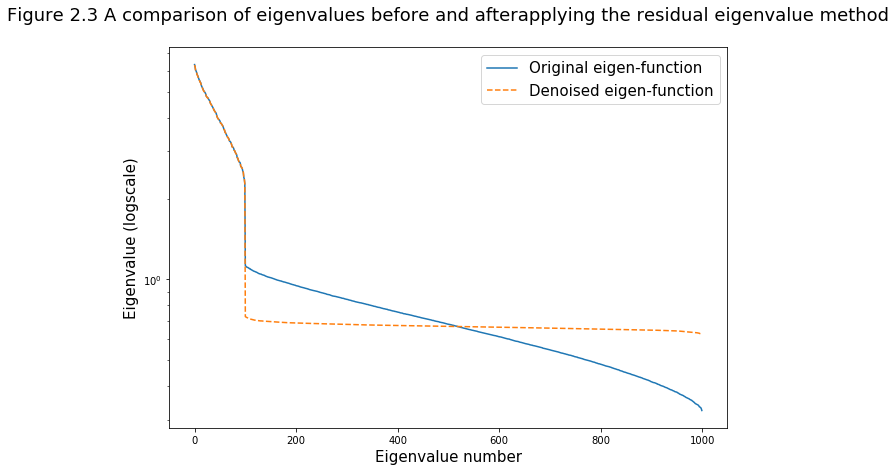

In [12]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('Figure 2.3 A comparison of eigenvalues before and afterapplying the residual eigenvalue method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.6 Denoising by targeted shrinkage

In [13]:
def denoisedCorr2(eVal, eVec, nFacts, alpha = 0) :
    # Remove noisse from corr through targeted shrinkage
    
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:,:nFacts]
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:,nFacts:]
    
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)

    
    corr2 = corr0 + alpha * corr1 + (1-alpha) * np.diag(np.diag(corr1))
    
    return corr2

### Figure 2.4 A comparison of eigenvalues before and after applying the targeted shrinkage method

In [14]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 0.5)

eVal1, eVec = getPCA(corr1)

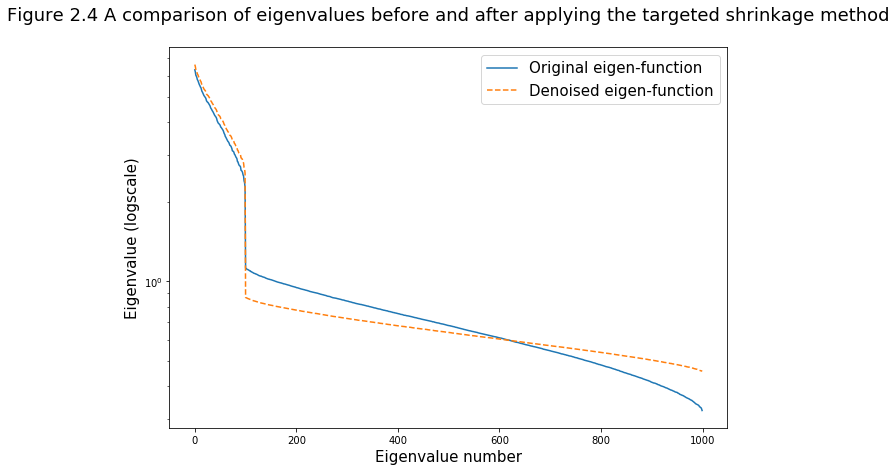

In [15]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('Figure 2.4 A comparison of eigenvalues before and after applying the targeted shrinkage method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Extra Figures (alpha variation)

#### The Targeted shrinkage method with alpha 0.0

In [16]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 0.0)

eVal1, eVec = getPCA(corr1)

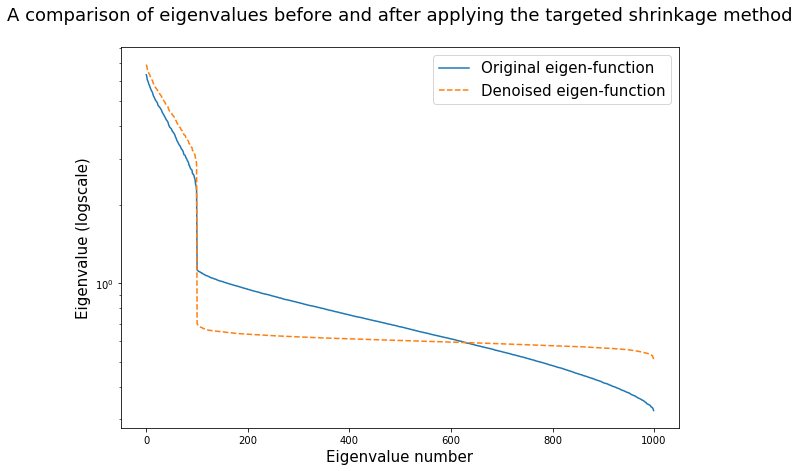

In [17]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('A comparison of eigenvalues before and after applying the targeted shrinkage method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

#### The Targeted shrinkage method with alpha 1.0

In [18]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 1.0)

eVal1, eVec = getPCA(corr1)

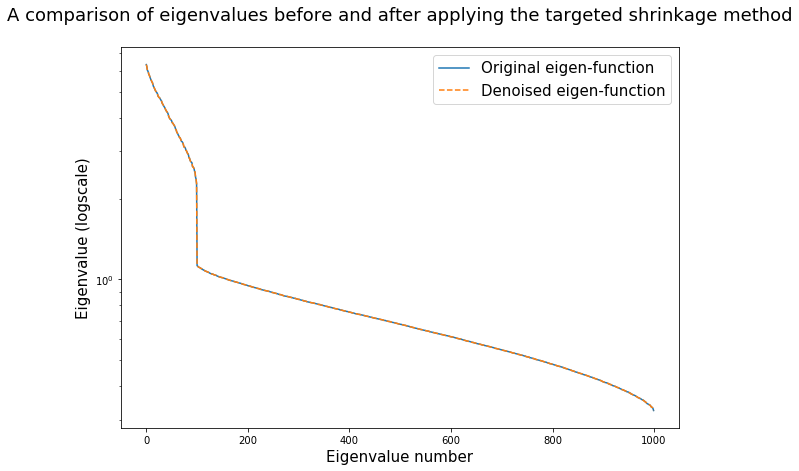

In [19]:
# Make Graphs

fig, ax = plt.subplots(figsize=(10,7))


ax.plot(np.diag(eVal0), label = "Original eigen-function")
ax.plot(np.diag(eVal1), "--",label = "Denoised eigen-function")

ax.set_title('A comparison of eigenvalues before and after applying the targeted shrinkage method\n', fontsize = 18)
ax.set_ylabel('Eigenvalue (logscale)', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Eigenvalue number', fontsize = 15)
leg = ax.legend(fontsize= 15)

### Snippet 2.7 Generating a Block-Diagonal Covariance Matrix and a Vector of Means

In [22]:
np.ones((5,5)) * 5

array([[5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.]])

In [54]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

# pre-define functions at Snippet 2.9
def corr2cov(corr, std):
    cov = corr * np.outer(std,std)
    return cov


def formBlockMatrix(nBlocks, bSize, bCorr) :
    # make square matrix (bSize * bSize) (all elements' value is bCorr)
    block = np.ones((bSize, bSize)) * bCorr
    
    # change diagonal elements to 1
    block[range(bSize), range(bSize)] = 1
    
    # Make block diagonal matrix with size (bSize*nBlocks by bSize*nBlocks)
    corr = block_diag(*([block]*nBlocks))
    
    return corr


def formTrueMatrix(nBlocks, bSize, bCorr) :
    
    # make BlockMatrix in DataFrame Format
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    
    # make columns index to list and shuffle
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    
    # corr matrix shuffled along column & index
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    
    # final calculations
    std0 = np.random.uniform(low = 0.05, high = 0.2, size = corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(loc = std0, scale = std0, size = cov0.shape[0]).reshape(-1,1)
    
    return mu0, cov0



#### Function Execution

In [55]:
nBlocks = 10
bSize = 50
bCorr = 0.5
np.random.seed(0)

mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

### Snippet 2.8 Generating the Empirical Covariance Matrix

In [70]:
def simCovMu(mu0, cov0, nObs, shrink=False):
    
    # TODO add comments
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = nObs)
    
    mu1 = x.mean(axis = 0).reshape(-1,1)
    
    if shrink :
        cov1 = LedoitWolf().fit(x).covariance_
    else :
        cov1 = np.cov(x, rowvar = 0)
    
    return mu1, cov1

### Snippet 2.9 Denoising of the Empirical Covariance Matrix

In [60]:
def corr2cov(corr, std):
    cov = corr * np.outer(std,std)
    return cov

def deNoiseCov(cov0, q, bWidth):
    
    # TODO add comments
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    
    # Finding noise starting point
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    
    cov1 = corr2cov(corr1, np.diag(cov0)** 0.5)
    
    return cov1

### Snippet 2.10 Denoising of the Emprical Covariance Matrix

In [61]:
def optPort(cov, mu=None):
    
    # TODO explain the function
    
    inv = np.linalg.inv(cov)
    ones = np.ones(shape = (inv.shape[0], 1))
    if mu is None :
        mu = ones
        
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)
    
    return w


#### Code Execution

In [67]:
nObs = 1000
nTrials = 1000
bWidth = 0.01
shrink = False
minVarPortf = True # TODO what is this?
np.random.seed(0)

In [71]:
w1 = pd.DataFrame(columns = range(cov0.shape[0]),
                 index = range(nTrials),
                 dtype = float)
w1_d = w1.copy(deep=True)

for i in range(nTrials) :
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf :
        mu1 = None
    
    cov1_d = deNoiseCov(cov1, nObs*1.0 / cov1.shape[1], bWidth)
    
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

### Snippet 2.11 Root-Mean-Square Errors

In [72]:
# TODO explain the codes

w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(a = w0.T, repeats = w1.shape[0], axis = 0)

# RMSE
rmsd = np.mean((w1 - w0).values.flatten()**2)** 0.5

# RMSE
rmsd_d = np.mean((w1_d - w0).values.flatten()**2)** 0.5

print(rmsd, rmsd_d)

0.004946938937596557 0.0011395470088907305
